In [37]:
import pandas as pd
import numpy as np
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better-looking plots
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    try:
        plt.style.use('seaborn-darkgrid')
    except:
        plt.style.use('ggplot')
sns.set_palette("husl")

Matplotlib is building the font cache; this may take a moment.


In [38]:
"""
Load the feature-engineered dataset prepared by the feature engineering pipeline.
This dataset contains all relevant features extracted from the SQLite database
and processed through the feature engineering notebook.
"""
df = pd.read_csv("../data/processed/listing_features.csv")

print(f"Loaded {len(df)} rows from listing_features.csv")
df["price"].describe()

Loaded 20631 rows from listing_features.csv


count    20631.000000
mean       184.845136
std        138.551476
min         10.000000
25%         93.000000
50%        147.000000
75%        229.000000
max       1000.000000
Name: price, dtype: float64

In [39]:
"""
Apply data quality filters to remove outliers and invalid records.
This step ensures that the model trains on realistic and valid data points,
preventing extreme values from skewing the model's predictions.
"""
rows_before = len(df)

"""
Establish reasonable bounds for the target variable to eliminate
unrealistic pricing that may represent data entry errors or special cases.
"""
df = df[df["price"].between(10, 1000)]

"""
Apply domain-specific constraints to key property characteristics.
These filters ensure that accommodation features fall within
realistic ranges observed in typical Airbnb listings.
"""
df = df[
    (df["accommodates"].between(1, 10)) &
    (df["bedrooms"].between(0, 8)) &
    (df["beds"].between(0, 10)) &
    (df["bathrooms"].between(0, 5)) &
    (df["review_scores_rating"].between(1, 5)) &
    (df["availability_365"].between(0, 365))
]

"""
Apply conditional filters for engineered features that may not
be present in all dataset versions, ensuring robustness.
"""
if "host_years" in df.columns:
    df = df[df["host_years"].between(0, 20)]
if "reviews_per_month" in df.columns:
    df = df[df["reviews_per_month"].between(0, 20)]

print(f"Rows before cleaning: {rows_before}")
print(f"Rows after cleaning:  {len(df)}")
df["price"].describe()

Rows before cleaning: 20631
Rows after cleaning:  20631


count    20631.000000
mean       184.845136
std        138.551476
min         10.000000
25%         93.000000
50%        147.000000
75%        229.000000
max       1000.000000
Name: price, dtype: float64

In [40]:
"""
Extract the target variable for model training and evaluation.
The price column represents the nightly rental rate, which is the
primary outcome we seek to predict.
"""
y = df["price"]

In [41]:
"""
Define feature groups for model training, carefully excluding
features that would introduce data leakage. Features derived from
the target variable are explicitly excluded to maintain model integrity.
"""
target_col = "price"

"""
Categorical features represent discrete groupings that require
encoding before model training. These include geographic and
property classification variables.
"""
categorical_features = [
    "city",
    "borough",
    "neighbourhood_name",
    "room_type",
    "property_type_grouped",
    "capacity_bucket",
    "host_listings_bucket",
    "rating_bucket",
]

"""
Binary features are boolean indicators that can be used directly
in numeric models without additional encoding.
"""
binary_features = [
    "host_is_superhost",
    "instant_bookable",
    "is_entire_home",
    "is_private_room",
    "is_shared_room",
    "is_hotel_room",
]

"""
Price-derived features must be excluded to prevent data leakage.
These features contain information about the target variable that
would not be available during actual prediction scenarios.
"""
price_leak_cols = [
    "price_per_accommodate",
    "price_per_bed",
    "price_per_bedroom",
    "price_minus_neigh_mean",
    "price_over_neigh_mean",
    "price_minus_neigh_median",
    "price_over_neigh_median",
    "neigh_avg_price",
    "neigh_median_price",
    "estimated_revenue",
]

"""
Compile a comprehensive list of columns to exclude from model training,
including target variables, date strings, raw text fields, and
redundant aggregated features.
"""
exclude_cols = (
    [target_col, "log_price"]
    + categorical_features
    + binary_features
    + price_leak_cols
    + ["host_since", "first_review", "last_review"]
    + ["property_type", "bathrooms_text", "host_since_dt", "host_name"]
    + ["city_listing_count", "city_avg_rating"]
)

"""
Identify numeric features by selecting all numeric columns that
are not in the exclusion list. These features will receive
standardization during preprocessing.
"""
numeric_features = [
    c for c in df.columns
    if c not in exclude_cols
    and pd.api.types.is_numeric_dtype(df[c])
]

print(f"Numeric features ({len(numeric_features)}):")
print(numeric_features)
print(f"\nCategorical features ({len(categorical_features)}):")
print(categorical_features)
print(f"\nBinary features ({len(binary_features)}):")
print(binary_features)

"""
Construct the feature matrix using only validated features that
do not introduce data leakage or redundancy.
"""
X = df[categorical_features + binary_features + numeric_features]

"""
Partition the dataset into training and testing subsets using
a fixed random seed to ensure reproducibility of results.
"""
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

print(f"\nTraining set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

"""
Establish a naive baseline model using the global mean price.
This provides a reference point for evaluating the performance
of more sophisticated modeling approaches.
"""
global_mean = y_train.mean()
print("Global mean price:", global_mean)

y_pred_global = np.full_like(y_test, fill_value=global_mean, dtype=float)

rmse_global = root_mean_squared_error(y_test, y_pred_global)
print("Global mean baseline RMSE:", rmse_global)

Numeric features (26):
['accommodates', 'bedrooms', 'beds', 'bathrooms', 'latitude', 'longitude', 'number_of_reviews', 'availability_365', 'review_scores_rating', 'calculated_host_listings_count', 'reviews_per_month', 'available_days_365', 'availability_rate_365', 'blocked_or_booked_days_365', 'blocked_or_booked_rate_365', 'log_number_of_reviews', 'log_reviews_per_month', 'availability_ratio', 'is_high_rating', 'is_active_host', 'host_years', 'neigh_listing_count', 'city_superhost_rate', 'city_avg_reviews_per_month', 'city_entire_home_share', 'log_city_listing_count']

Categorical features (8):
['city', 'borough', 'neighbourhood_name', 'room_type', 'property_type_grouped', 'capacity_bucket', 'host_listings_bucket', 'rating_bucket']

Binary features (6):
['host_is_superhost', 'instant_bookable', 'is_entire_home', 'is_private_room', 'is_shared_room', 'is_hotel_room']

Training set size: 16504
Test set size: 4127
Global mean price: 184.17074648570045
Global mean baseline RMSE: 143.0870102

In [42]:
"""
Establish a second baseline model using neighbourhood-level average prices.
This approach leverages geographic information to provide a more
sophisticated baseline than the global mean.
"""
train_indices = X_train.index
test_indices = X_test.index

"""
Calculate mean prices for each neighbourhood using only training data
to prevent information leakage from the test set.
"""
neigh_means = (
    df.loc[train_indices]
    .groupby("neighbourhood_name")["price"]
    .mean()
)

"""
Generate predictions by mapping test neighbourhoods to their
corresponding training set means, falling back to the global mean
for neighbourhoods not present in the training data.
"""
y_pred_neigh = df.loc[test_indices]["neighbourhood_name"].map(neigh_means)
y_pred_neigh = y_pred_neigh.fillna(global_mean)

rmse_neigh = root_mean_squared_error(y_test, y_pred_neigh)
print("Neighbourhood mean baseline RMSE:", rmse_neigh)

Neighbourhood mean baseline RMSE: 124.57374477100998


In [43]:
"""
Implement a linear regression model with comprehensive preprocessing.
This approach provides an interpretable baseline that captures
linear relationships between features and price.
"""
num_features = numeric_features + binary_features
cat_features = categorical_features

"""
Define preprocessing pipeline for numeric and binary features.
Missing values are imputed using the median, followed by standardization
to ensure all features contribute proportionally to the model.
"""
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

"""
Define preprocessing pipeline for categorical features.
Missing values are imputed using the most frequent category, followed
by one-hot encoding to convert categorical variables into numeric form.
"""
categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore")),
])

"""
Combine numeric and categorical transformers into a unified
preprocessing pipeline that applies appropriate transformations
to each feature type.
"""
preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features),
    ]
)

"""
Construct the complete modeling pipeline that integrates preprocessing
with the linear regression algorithm, enabling seamless training and prediction.
"""
linreg_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("regressor", LinearRegression())
])

"""
Train the linear regression model on the training dataset,
learning the optimal coefficients that minimize prediction error.
"""
linreg_model.fit(X_train, y_train)

"""
Generate predictions on the test set to evaluate model performance
on unseen data, providing an unbiased assessment of generalization capability.
"""
y_pred_lr = linreg_model.predict(X_test)

"""
Calculate comprehensive evaluation metrics to assess model performance.
Root mean squared error provides a scale-aware measure of prediction accuracy,
mean absolute error offers an intuitive interpretation of average error magnitude,
and R-squared quantifies the proportion of variance explained by the model.
"""
rmse_lr = sqrt(mean_squared_error(y_test, y_pred_lr))
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print("Global mean baseline RMSE:      ", rmse_global)
print("Neighbourhood mean baseline RMSE:", rmse_neigh)
print("Linear regression RMSE:         ", rmse_lr)
print("Linear regression MAE:          ", mae_lr)
print("Linear regression R^2:          ", r2_lr)

Global mean baseline RMSE:       143.08701026598013
Neighbourhood mean baseline RMSE: 124.57374477100998
Linear regression RMSE:          94.61117696759183
Linear regression MAE:           63.26836005160132
Linear regression R^2:           0.5625528138666831


In [44]:
"""
Implement a Random Forest regression model, an ensemble method that
combines multiple decision trees to capture non-linear relationships
and feature interactions that linear models cannot represent.
"""
rf_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("regressor", RandomForestRegressor(
        n_estimators=200,
        max_depth=None,
        n_jobs=-1,
        random_state=42
    ))
])

"""
Train the Random Forest model on the training dataset, constructing
an ensemble of decision trees that collectively provide robust predictions.
"""
rf_model.fit(X_train, y_train)

"""
Generate predictions on the test set using the trained Random Forest model,
leveraging the ensemble's ability to capture complex patterns in the data.
"""
y_pred_rf = rf_model.predict(X_test)

"""
Evaluate the Random Forest model's performance using the same metrics
as the linear regression model, enabling direct comparison of model effectiveness.
"""
rmse_rf = sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest RMSE:", rmse_rf)
print("Random Forest MAE: ", mae_rf)
print("Random Forest R^2: ", r2_rf)

Random Forest RMSE: 75.69445785138063
Random Forest MAE:  46.60657487278895
Random Forest R^2:  0.71999299101695


In [45]:
print("\n=== Model comparison on test set ===")
print(f"Global mean baseline RMSE:        {rmse_global:.2f}")
print(f"Neighbourhood mean baseline RMSE: {rmse_neigh:.2f}")
print(f"Linear Regression RMSE:           {rmse_lr:.2f}")
print(f"Random Forest RMSE:               {rmse_rf:.2f}")

print("\nMAE scores:")
print(f"Linear Regression MAE:            {mae_lr:.2f}")
print(f"Random Forest MAE:                {mae_rf:.2f}")

print("\nR^2 scores:")
print(f"Linear Regression R^2:            {r2_lr:.3f}")
print(f"Random Forest R^2:                {r2_rf:.3f}")



=== Model comparison on test set ===
Global mean baseline RMSE:        143.09
Neighbourhood mean baseline RMSE: 124.57
Linear Regression RMSE:           94.61
Random Forest RMSE:               75.69

MAE scores:
Linear Regression MAE:            63.27
Random Forest MAE:                46.61

R^2 scores:
Linear Regression R^2:            0.563
Random Forest R^2:                0.720


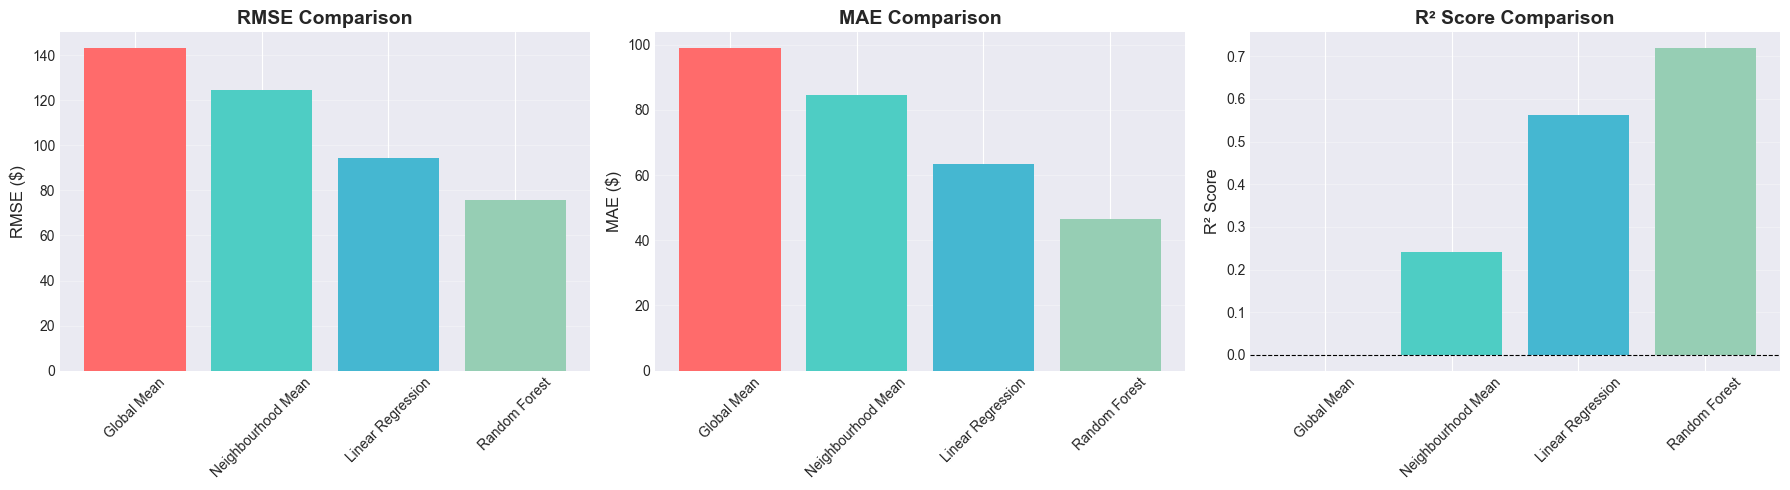

In [46]:
"""
Create visualizations to compare model performance and understand prediction patterns.
These graphs help identify model strengths, weaknesses, and areas for improvement.
"""

# 1. Model Comparison Bar Chart
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models = ['Global Mean', 'Neighbourhood Mean', 'Linear Regression', 'Random Forest']
rmse_scores = [rmse_global, rmse_neigh, rmse_lr, rmse_rf]
mae_scores = [mean_absolute_error(y_test, y_pred_global), 
              mean_absolute_error(y_test, y_pred_neigh),
              mae_lr, mae_rf]
r2_scores = [r2_score(y_test, y_pred_global),
             r2_score(y_test, y_pred_neigh),
             r2_lr, r2_rf]

# RMSE comparison
axes[0].bar(models, rmse_scores, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
axes[0].set_title('RMSE Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylabel('RMSE ($)', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# MAE comparison
axes[1].bar(models, mae_scores, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
axes[1].set_title('MAE Comparison', fontsize=14, fontweight='bold')
axes[1].set_ylabel('MAE ($)', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)

# R² comparison
axes[2].bar(models, r2_scores, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
axes[2].set_title('R² Score Comparison', fontsize=14, fontweight='bold')
axes[2].set_ylabel('R² Score', fontsize=12)
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(axis='y', alpha=0.3)
axes[2].axhline(y=0, color='black', linestyle='--', linewidth=0.8)

plt.tight_layout()
plt.show()


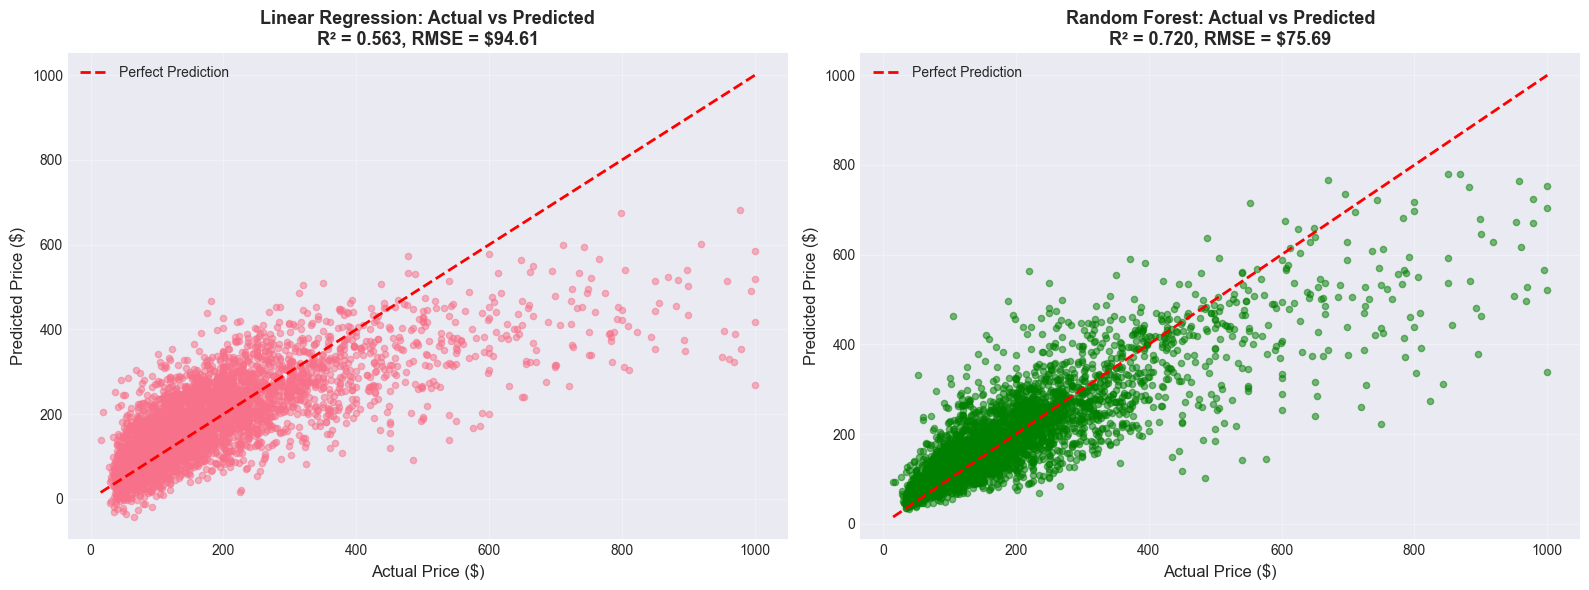

In [47]:
# 2. Actual vs Predicted Scatter Plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Linear Regression
axes[0].scatter(y_test, y_pred_lr, alpha=0.5, s=20)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Price ($)', fontsize=12)
axes[0].set_ylabel('Predicted Price ($)', fontsize=12)
axes[0].set_title(f'Linear Regression: Actual vs Predicted\nR² = {r2_lr:.3f}, RMSE = ${rmse_lr:.2f}', 
                  fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Random Forest
axes[1].scatter(y_test, y_pred_rf, alpha=0.5, s=20, color='green')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Price ($)', fontsize=12)
axes[1].set_ylabel('Predicted Price ($)', fontsize=12)
axes[1].set_title(f'Random Forest: Actual vs Predicted\nR² = {r2_rf:.3f}, RMSE = ${rmse_rf:.2f}', 
                  fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


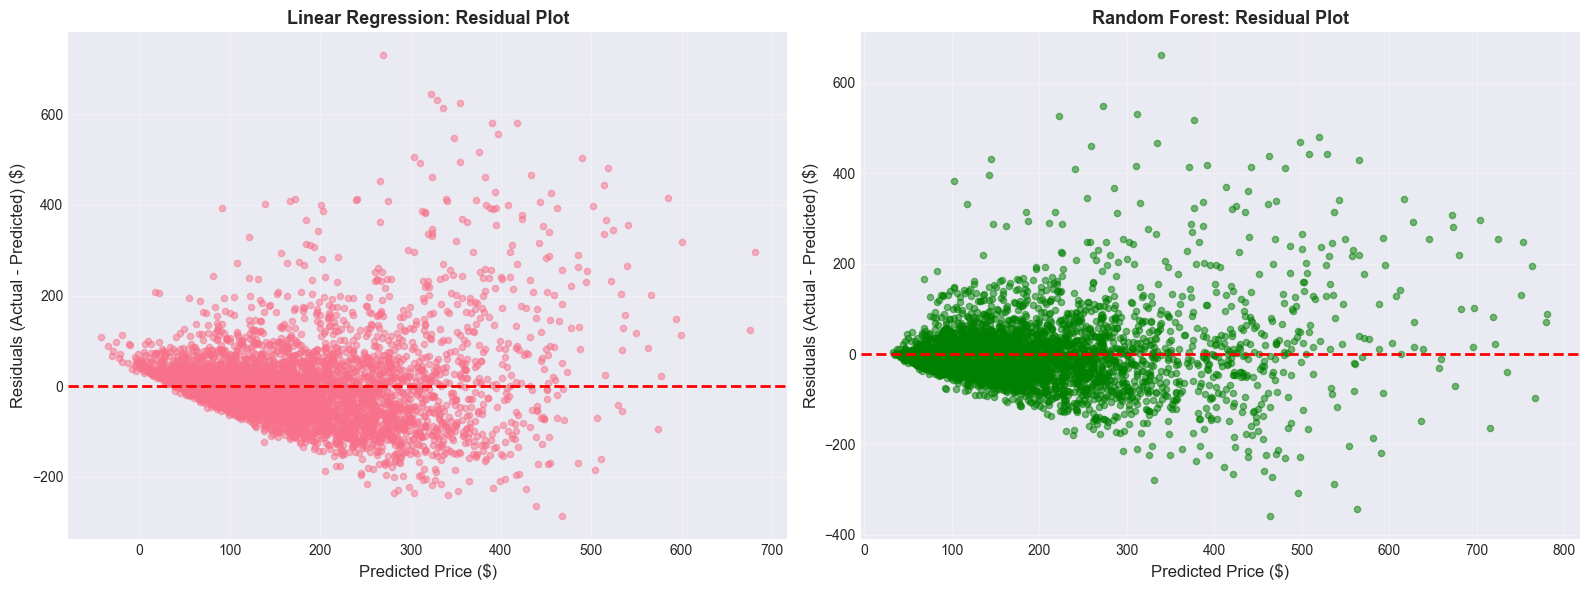

In [48]:
# 3. Residual Plots (to check for patterns in errors)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Calculate residuals
residuals_lr = y_test - y_pred_lr
residuals_rf = y_test - y_pred_rf

# Linear Regression residuals
axes[0].scatter(y_pred_lr, residuals_lr, alpha=0.5, s=20)
axes[0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0].set_xlabel('Predicted Price ($)', fontsize=12)
axes[0].set_ylabel('Residuals (Actual - Predicted) ($)', fontsize=12)
axes[0].set_title('Linear Regression: Residual Plot', fontsize=13, fontweight='bold')
axes[0].grid(alpha=0.3)

# Random Forest residuals
axes[1].scatter(y_pred_rf, residuals_rf, alpha=0.5, s=20, color='green')
axes[1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Predicted Price ($)', fontsize=12)
axes[1].set_ylabel('Residuals (Actual - Predicted) ($)', fontsize=12)
axes[1].set_title('Random Forest: Residual Plot', fontsize=13, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


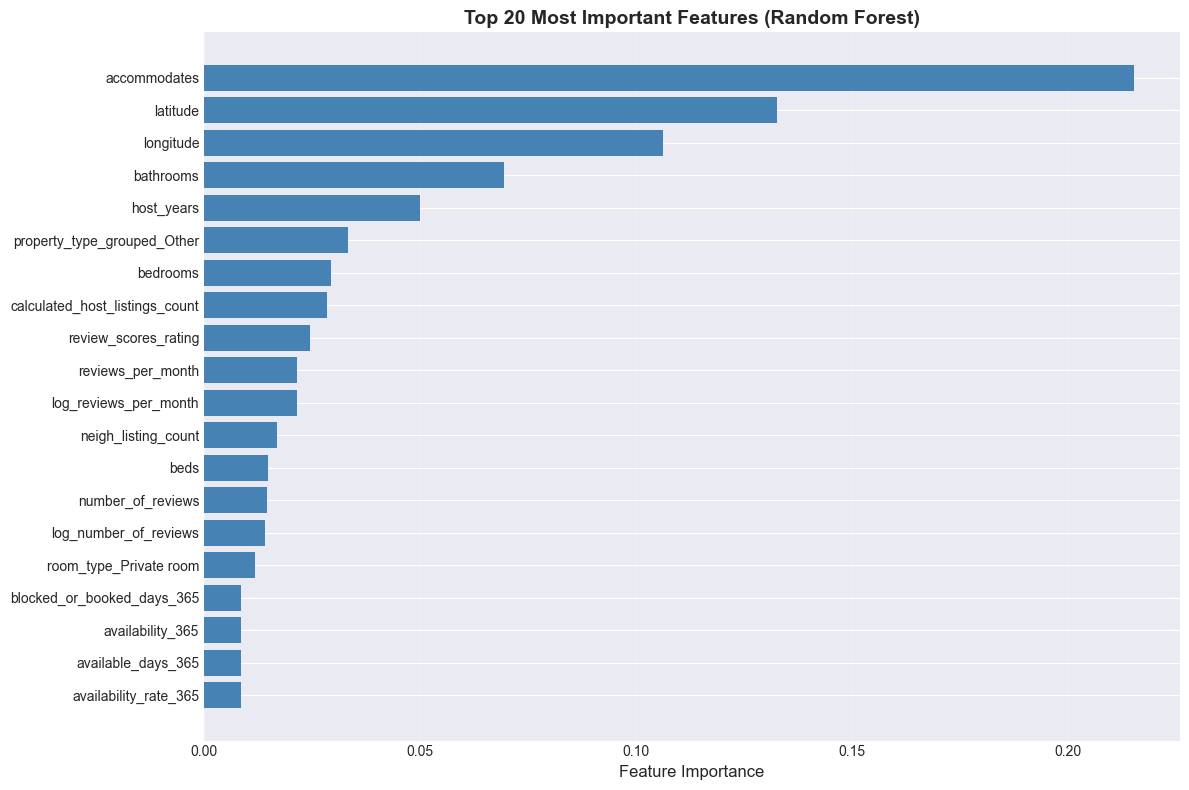


Top 10 Most Important Features:
                       feature  importance
                  accommodates    0.215138
                      latitude    0.132632
                     longitude    0.106309
                     bathrooms    0.069478
                    host_years    0.049909
   property_type_grouped_Other    0.033305
                      bedrooms    0.029472
calculated_host_listings_count    0.028336
          review_scores_rating    0.024576
             reviews_per_month    0.021612


In [49]:
# 4. Feature Importance for Random Forest
rf_regressor = rf_model.named_steps['regressor']
feature_names = numeric_features + binary_features + categorical_features

# Get feature names after preprocessing
preprocessor = rf_model.named_steps['preprocess']
feature_names_processed = []

# Get numeric feature names
feature_names_processed.extend(numeric_features + binary_features)

# Get categorical feature names (one-hot encoded)
cat_transformer = preprocessor.named_transformers_['cat']
if hasattr(cat_transformer, 'named_steps'):
    encoder = cat_transformer.named_steps['encoder']
    if hasattr(encoder, 'get_feature_names_out'):
        cat_feature_names = encoder.get_feature_names_out(categorical_features)
        feature_names_processed.extend(cat_feature_names)
    else:
        # Fallback for older sklearn versions
        n_cat_features = sum(len(df[cat].unique()) for cat in categorical_features)
        feature_names_processed.extend([f'cat_{i}' for i in range(n_cat_features)])
else:
    n_cat_features = sum(len(df[cat].unique()) for cat in categorical_features)
    feature_names_processed.extend([f'cat_{i}' for i in range(n_cat_features)])

# Get feature importances
importances = rf_regressor.feature_importances_

# Create a DataFrame for easier handling
importance_df = pd.DataFrame({
    'feature': feature_names_processed[:len(importances)],
    'importance': importances
}).sort_values('importance', ascending=False)

# Plot top 20 most important features
top_n = min(20, len(importance_df))
plt.figure(figsize=(12, 8))
plt.barh(range(top_n), importance_df.head(top_n)['importance'], color='steelblue')
plt.yticks(range(top_n), importance_df.head(top_n)['feature'])
plt.xlabel('Feature Importance', fontsize=12)
plt.title(f'Top {top_n} Most Important Features (Random Forest)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nTop 10 Most Important Features:")
print(importance_df.head(10)[['feature', 'importance']].to_string(index=False))


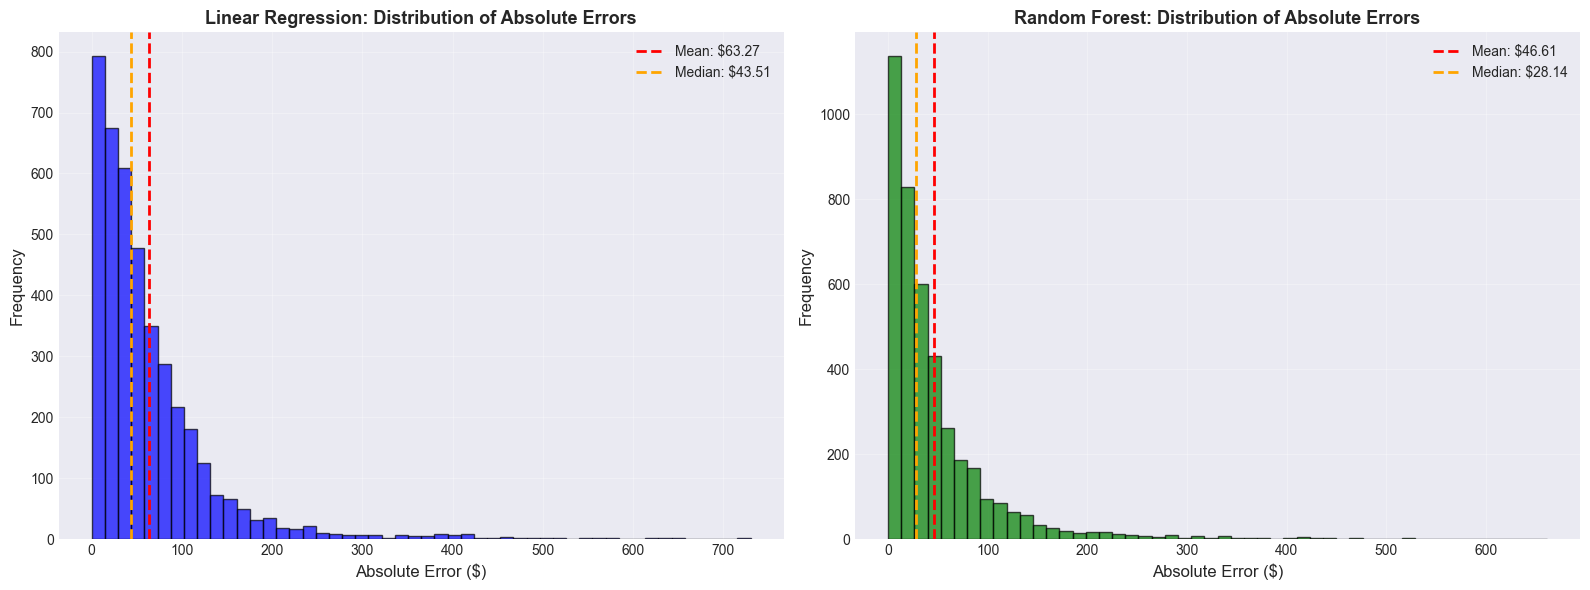

In [50]:
# 5. Error Distribution Comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Calculate absolute errors
abs_errors_lr = np.abs(residuals_lr)
abs_errors_rf = np.abs(residuals_rf)

# Linear Regression error distribution
axes[0].hist(abs_errors_lr, bins=50, alpha=0.7, color='blue', edgecolor='black')
axes[0].axvline(abs_errors_lr.mean(), color='red', linestyle='--', linewidth=2, 
                label=f'Mean: ${abs_errors_lr.mean():.2f}')
axes[0].axvline(abs_errors_lr.median(), color='orange', linestyle='--', linewidth=2, 
                label=f'Median: ${abs_errors_lr.median():.2f}')
axes[0].set_xlabel('Absolute Error ($)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Linear Regression: Distribution of Absolute Errors', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Random Forest error distribution
axes[1].hist(abs_errors_rf, bins=50, alpha=0.7, color='green', edgecolor='black')
axes[1].axvline(abs_errors_rf.mean(), color='red', linestyle='--', linewidth=2, 
                label=f'Mean: ${abs_errors_rf.mean():.2f}')
axes[1].axvline(abs_errors_rf.median(), color='orange', linestyle='--', linewidth=2, 
                label=f'Median: ${abs_errors_rf.median():.2f}')
axes[1].set_xlabel('Absolute Error ($)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Random Forest: Distribution of Absolute Errors', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


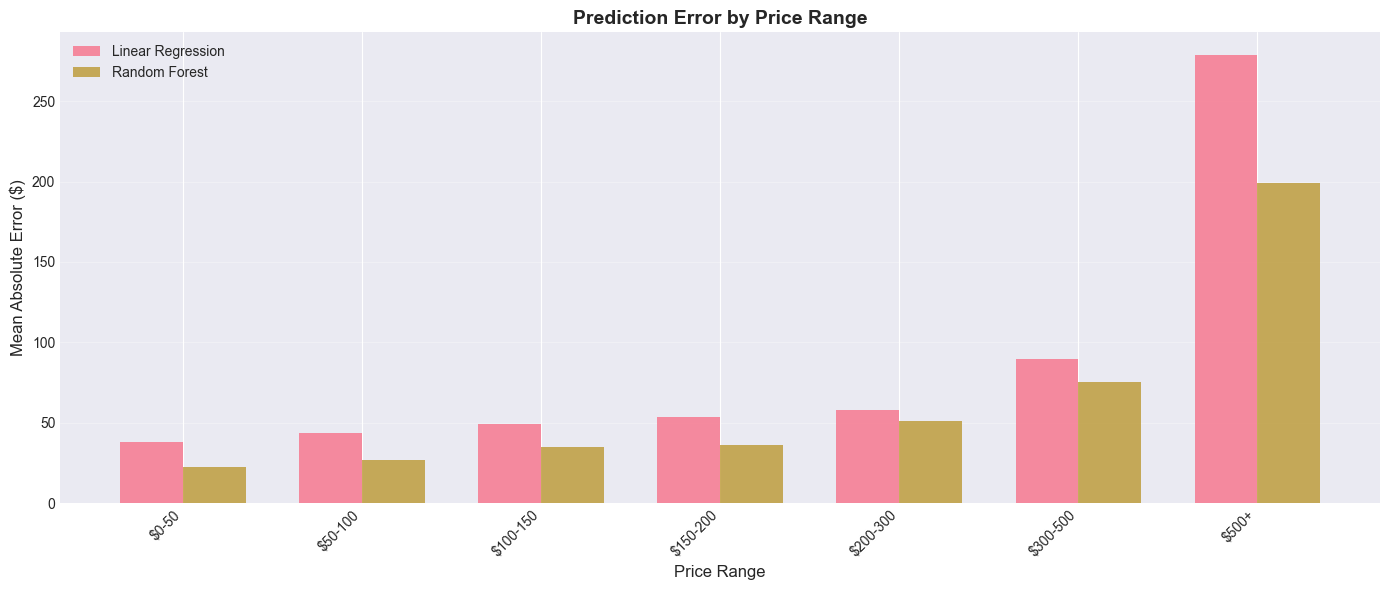

In [51]:
# 6. Prediction Error by Price Range
# Create price bins to analyze error patterns across different price ranges
price_bins = [0, 50, 100, 150, 200, 300, 500, 1000]
price_labels = ['$0-50', '$50-100', '$100-150', '$150-200', '$200-300', '$300-500', '$500+']
y_test_binned = pd.cut(y_test, bins=price_bins, labels=price_labels)

# Calculate mean absolute error for each price range
mae_by_range_lr = []
mae_by_range_rf = []
for label in price_labels:
    mask = y_test_binned == label
    if mask.sum() > 0:
        mae_by_range_lr.append(abs_errors_lr[mask].mean())
        mae_by_range_rf.append(abs_errors_rf[mask].mean())
    else:
        mae_by_range_lr.append(0)
        mae_by_range_rf.append(0)

# Plot
x = np.arange(len(price_labels))
width = 0.35

fig, ax = plt.subplots(figsize=(14, 6))
bars1 = ax.bar(x - width/2, mae_by_range_lr, width, label='Linear Regression', alpha=0.8)
bars2 = ax.bar(x + width/2, mae_by_range_rf, width, label='Random Forest', alpha=0.8)

ax.set_xlabel('Price Range', fontsize=12)
ax.set_ylabel('Mean Absolute Error ($)', fontsize=12)
ax.set_title('Prediction Error by Price Range', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(price_labels, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()
